In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2/*.txt')
files_nm = glob.glob('../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2/*p*.txt')

#here is where the output will go 
path_save_1 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Cruve_Fe_2120_21_22_23_part2.csv'
path_save_2 = '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_part2.csv'
files

['../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\000_nm_post_Absorbance__1__13-19-01-823.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\000_nm_post_Absorbance__2__13-19-09-534.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\010_nm_post_Absorbance__0__13-20-47-345.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\020_nm_post_Absorbance__0__13-21-22-995.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\050_nm_post_Absorbance__1__13-22-49-243.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\100_nm_post_Absorbance__0__13-23-58-475.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\200_nm_post_Absorbance__0__13-24-42-895.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_Rerun/Fe_2120_21_22_23_Part2\\212106_Absorbance__0__12-49-12-463.txt',
 '../Dissertation_projects/Data/IRON/WC_FeT_R

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

In [5]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

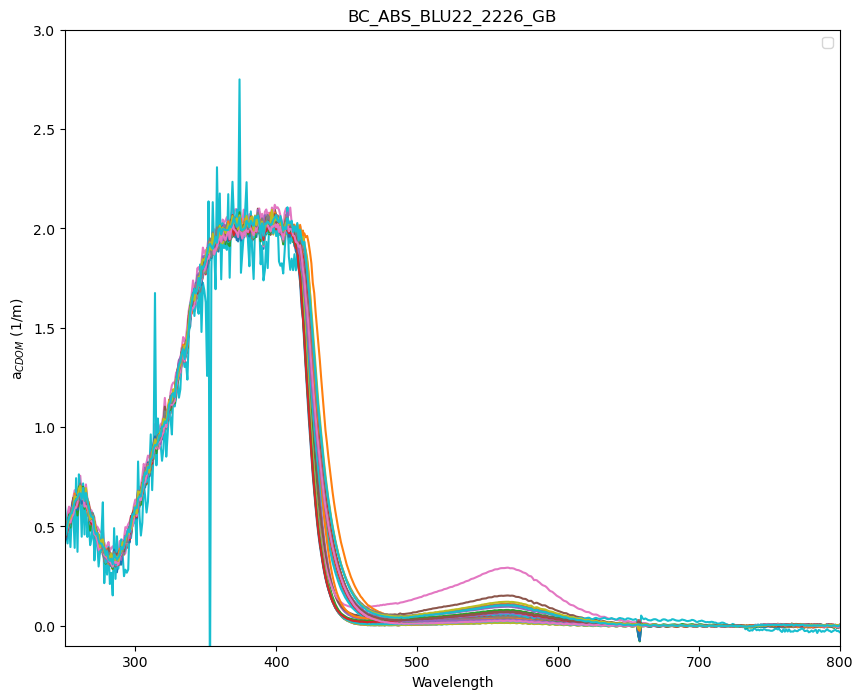

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("BC_ABS_BLU22_2226_GB")


Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

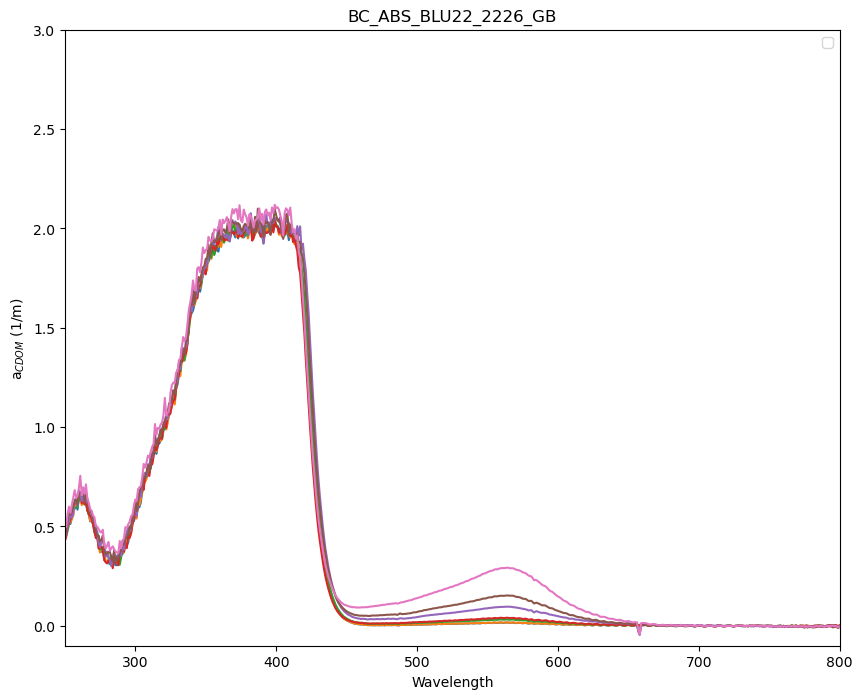

In [7]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df_nm.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("BC_ABS_BLU22_2226_GB")


PART 1 
THE CURVE

In [8]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.items():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('Abs', n=7).str[0]

In [9]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

,abs_562,intagration,conc,ID
sample,,,,
000_nm_post_Absorbance__1__13-19-01-823.txt,0.015466,1.786390,0,000_nm_post_
000_nm_post_Absorbance__2__13-19-09-534.txt,0.016439,1.932230,0,000_nm_post_
010_nm_post_Absorbance__0__13-20-47-345.txt,0.031070,3.578904,10,010_nm_post_
020_nm_post_Absorbance__0__13-21-22-995.txt,0.039076,4.385067,20,020_nm_post_
050_nm_post_Absorbance__1__13-22-49-243.txt,0.096061,10.567299,50,050_nm_post_
100_nm_post_Absorbance__0__13-23-58-475.txt,0.151514,16.246424,100,100_nm_post_
200_nm_post_Absorbance__0__13-24-42-895.txt,0.290769,31.452274,200,200_nm_post_


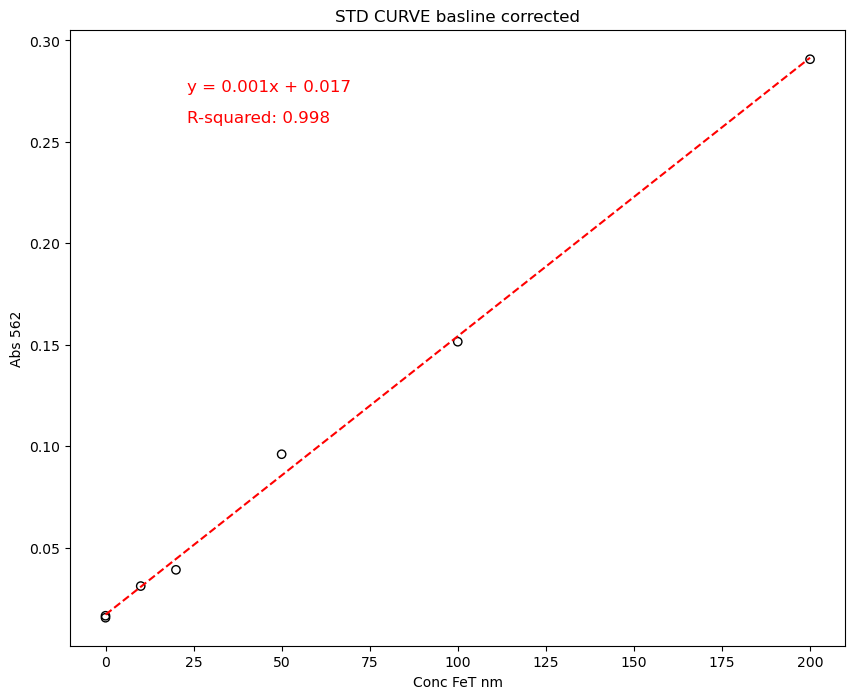

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


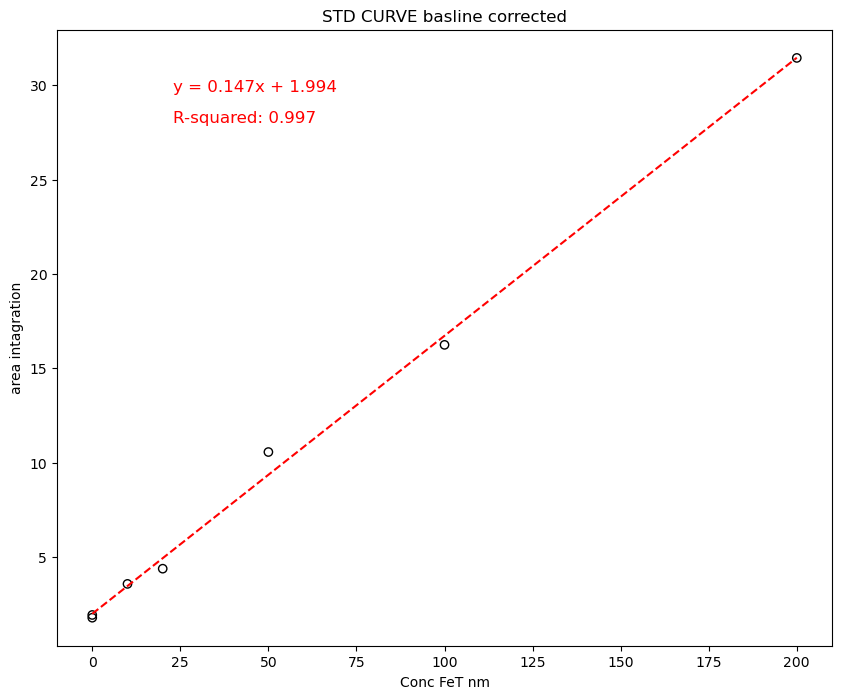

In [11]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [12]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


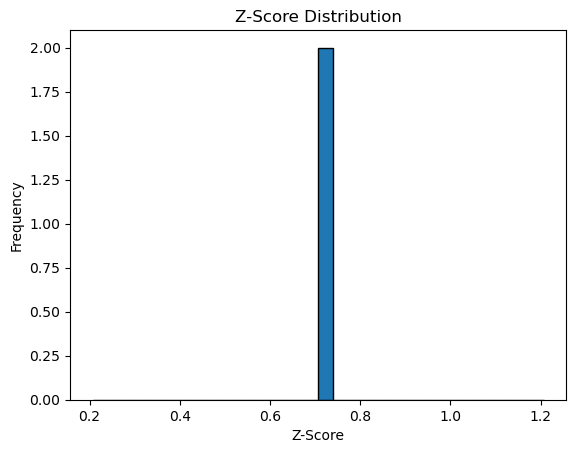

Empty DataFrame
Columns: [abs_562, intagration, conc, ID, mean, std, z_score]
Index: []


In [13]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [14]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

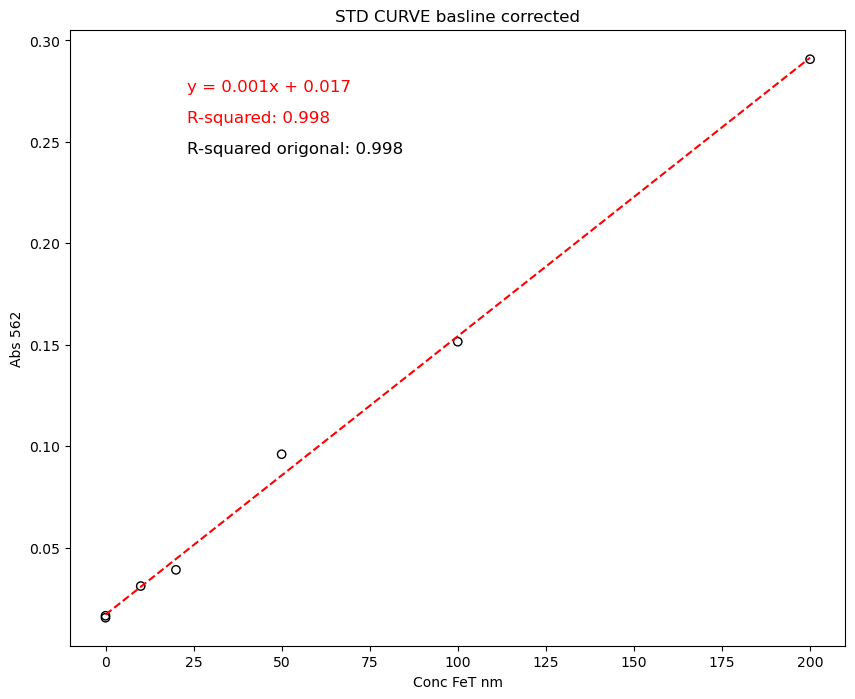

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


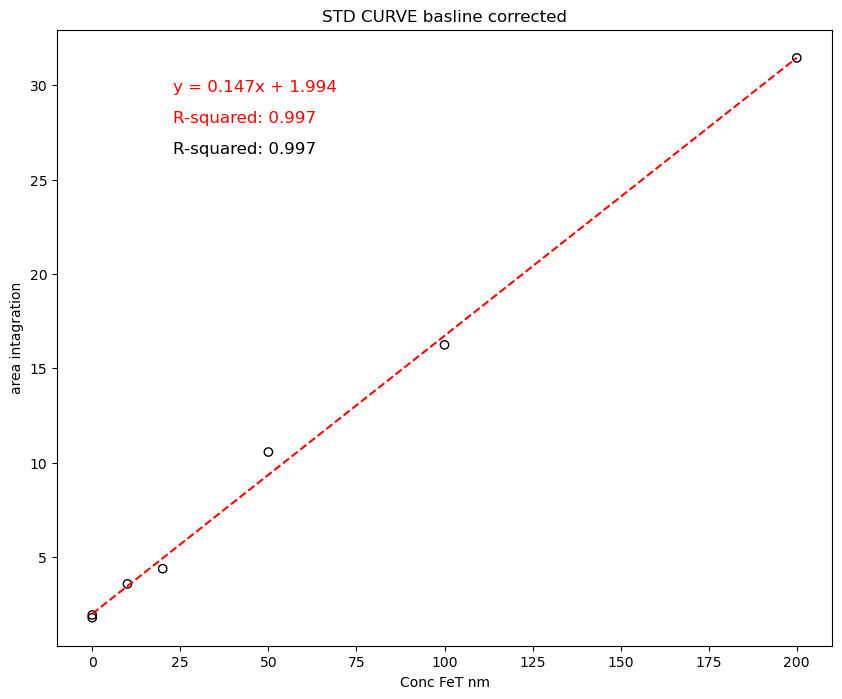

In [16]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [17]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('conc', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs #.groupby(std_outs['ID']).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

,abs_562,intagration,ID,mean,std,z_score
conc,,,,,,
0,0.015466,1.786390,000_nm_post_,0.015952,0.000688,0.707107
0,0.016439,1.932230,000_nm_post_,0.015952,0.000688,0.707107
10,0.031070,3.578904,010_nm_post_,0.031070,NaN,NaN
20,0.039076,4.385067,020_nm_post_,0.039076,NaN,NaN
50,0.096061,10.567299,050_nm_post_,0.096061,NaN,NaN
100,0.151514,16.246424,100_nm_post_,0.151514,NaN,NaN
200,0.290769,31.452274,200_nm_post_,0.290769,NaN,NaN


PART 2
THE DATA

In [18]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.items():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

,abs_562,intagration
sample,,
212106_Absorbance__0__12-49-12-463.txt,0.031563,5.435381
212107_Absorbance__0__12-49-53-721.txt,0.029579,4.800580
212108_Absorbance__0__12-50-47-302.txt,0.017004,3.100220
212109_Absorbance__0__12-51-27-740.txt,0.027276,5.060996
212109_Absorbance__1__12-51-59-202.txt,0.052170,10.051473
212110_Absorbance__0__12-52-43-026.txt,0.028133,5.389208
212201_Absorbance__0__12-57-26-830.txt,0.051239,7.370373
212202_Absorbance__0__12-58-18-365.txt,0.040984,5.780234
212203_Absorbance__0__12-58-58-022.txt,0.027983,4.386854


In [19]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']

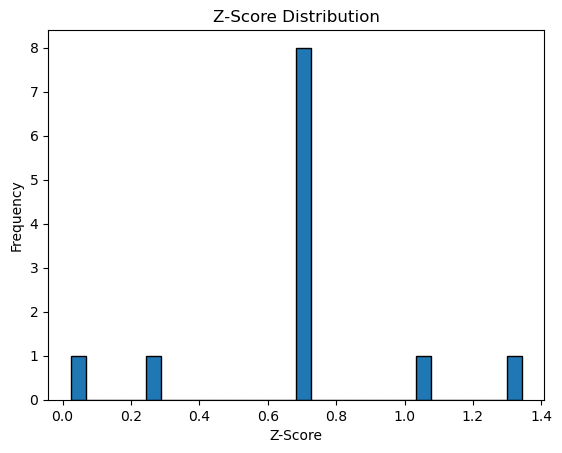

                                         abs_562  intagration group_name  \
sample                                                                     
212109_Absorbance__0__12-51-27-740.txt  0.027276     5.060996     212109   
212109_Absorbance__1__12-51-59-202.txt  0.052170    10.051473     212109   
212208_Absorbance__0__13-02-23-945.txt  0.032778     5.067733     212208   
212208_Absorbance__2__13-02-25-823.txt  0.033715     5.083735     212208   
212303_Absorbance__0__13-08-06-083.txt  0.026738     4.703647     212303   
212303_Absorbance__1__13-08-07-124.txt  0.026752     4.668239     212303   
212305_Absorbance__0__13-09-58-237.txt  0.035706     5.158386     212305   
212305_Absorbance__1__13-10-14-916.txt  0.036352     5.342327     212305   
CS2_Absorbance__0__12-55-22-061.txt     0.076156     7.771437        CS2   
CS2_Absorbance__1__12-55-56-567.txt     0.110366    11.815659        CS2   

                                            mean       std   z_score  
sample          

In [20]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [21]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: 212109
Index of row with highest z_score: 
Index(['212109_Absorbance__1__12-51-59-202.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
212109_Absorbance__0__12-51-27-740.txt    0.707107
212109_Absorbance__1__12-51-59-202.txt    0.707107
Name: z_score, dtype: float64

Group: 212208
Index of row with highest z_score: 
Index(['212208_Absorbance__0__13-02-23-945.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
212208_Absorbance__0__13-02-23-945.txt    1.342433
212208_Absorbance__1__13-02-24-990.txt    0.254353
212208_Absorbance__2__13-02-25-823.txt    1.064242
212208_Absorbance__3__13-02-26-240.txt    0.023837
Name: z_score, dtype: float64

Group: 212303
Index of row with highest z_score: 
Index(['212303_Absorbance__0__13-08-06-083.txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
212303_Absorbance__0__13-08-06-083.txt    0.707107
212303_Absorbance__1__13-08-07-124.txt    0.707107
Name: z_score, dtype: float64

Grou

In [22]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

,abs_562,intagration,mean,std,z_score
group_name,,,,,
212106,0.031563,5.435381,0.031563,NaN,NaN
212107,0.029579,4.800580,0.029579,NaN,NaN
212108,0.017004,3.100220,0.017004,NaN,NaN
212109,0.027276,5.060996,0.039723,0.017603,0.707107
212110,0.028133,5.389208,0.028133,NaN,NaN
212201,0.051239,7.370373,0.051239,NaN,NaN
212202,0.040984,5.780234,0.040984,NaN,NaN
212203,0.027983,4.386854,0.027983,NaN,NaN
212204,0.041758,5.865672,0.041758,NaN,NaN
